In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import datetime
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [2]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

In [3]:
df = pd.read_csv(path + "NYPD_Motor_Vehicle_Collisions.csv", parse_dates=[['DATE', 'TIME']], infer_datetime_format=True)

In [4]:
df['DATE_TIME'] = pd.to_numeric(df['DATE_TIME'])
df = df.sort_values('DATE_TIME', axis=0, ascending=True)

Loop through the directory

In [5]:
datasets = {}

for file in os.listdir(path+"data_for_joining/"):
    if file.endswith(".pkl") and "injury_avgs" not in file:
        with open(os.path.join(path+"data_for_joining/", file), 'rb') as pkl_file:
            datasets[file.replace(".pkl", "")] = pickle.load(pkl_file, encoding='latin1')

In [6]:
for key, value in datasets.items() :
    if "traffic" in key:
        datasets[key].name = datasets[key].name + '_' + key.split('_')[-1]
    df = df.join(datasets[key], on='UNIQUE KEY', how='left', rsuffix="_"+key)
    print ("%s finished!" % (key))

311_joined finished!
lights finished!
traffic_joined_0.03 finished!
weather_joined_utm finished!
traffic_joined_0.1 finished!
daylight_joined finished!
subway_joined finished!
Bank_Holidays finished!
lat_long_inferred finished!
traffic_joined_0.3 finished!
self finished!
traffic_joined_0.06 finished!


In [7]:
df.set_index('UNIQUE KEY', inplace=True)

Replace values with inferred lat long values

In [8]:
inferred_datasets = {}

for file in os.listdir(path+"inferred_lat_long_data/"):
    if file.endswith(".pkl"):
        with open(os.path.join(path+"inferred_lat_long_data/", file), 'rb') as pkl_file:
            inferred_datasets[file.replace(".pkl", "")] = pickle.load(pkl_file, encoding='latin1')

In [9]:
for key, value in inferred_datasets.items():
    try:
        replace_columns = inferred_datasets[key].columns.values
    except:
        replace_columns = inferred_datasets[key].name
        
    df.loc[inferred_datasets[key].index, replace_columns] = inferred_datasets[key]
    print ("%s finished!" % (key))

new_lat_long finished!
traffic_joined_0.3LATLONGCLEANED finished!
311_joined finished!
traffic_joined_0.03LATLONGCLEANED finished!
weather_joined_utm finished!
traffic_joined_0.1LATLONGCLEANED finished!
subway_joined finished!
traffic_joined_0.06LATLONGCLEANED finished!


In [10]:
renamed_columns = [x.lower().replace(' ', '_').replace('_bin', '') for x in df.columns.values]
    
df.columns = renamed_columns

In [11]:
df.ix[df.longitude[df.longitude < -100].index,'longitude'] = np.nan

(0, 10000)

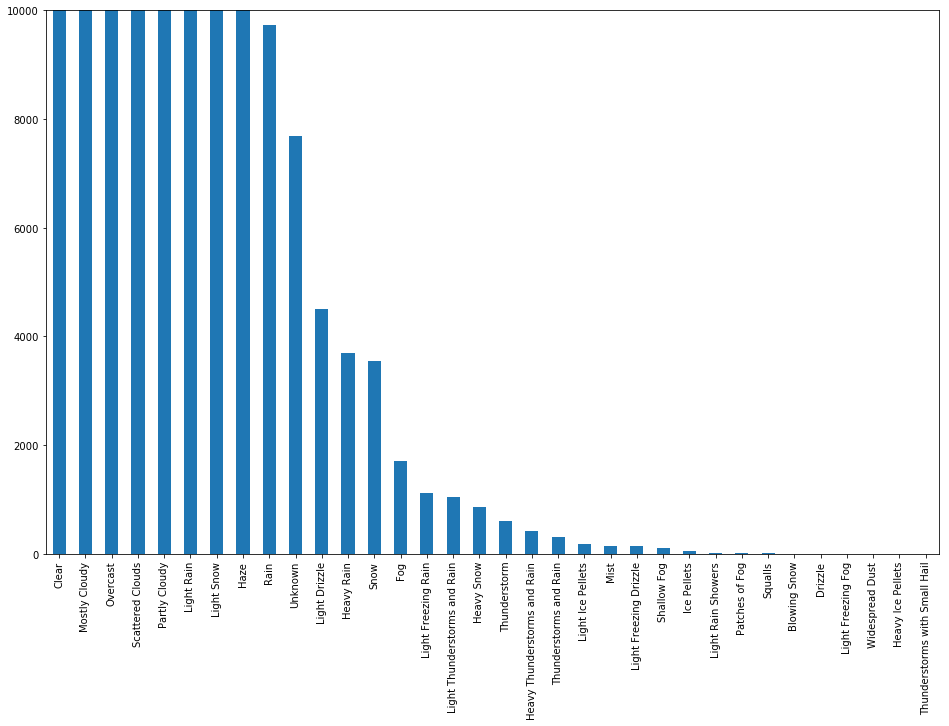

In [12]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

In [13]:
remap_weather = {'Heavy Snow': 'Snow',
                'Light Freezing Rain': 'Light Rain',
                'Heavy Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Thunderstorms and Rain': 'Thunderstorms and Rain',
                'Light Ice Pellets': 'Ice Pellets',
                'Heavy Ice Pellets': 'Ice Pellets',
                'Thunderstorms with Small Hail': 'Thunderstorms and Rain',
                'Shallow Fog': 'Fog',
                'Light Freezing Fog': 'Fog',
                'Mist': 'Fog',
                'Blowing Snow': 'Snow',
                'Drizzle': 'Light Rain',
                'Widespread Dust': 'Haze',
                'Squalls': np.nan,
                'Unknown': np.nan,
                'Light Drizzle': 'Light Rain',
                'Light Freezing Drizzle': 'Light Rain',
                'Patches of Fog': 'Fog',
                'Light Rain Showers': 'Light Rain',
                }

df['conditions'] = df['conditions'].replace(remap_weather)

(0, 10000)

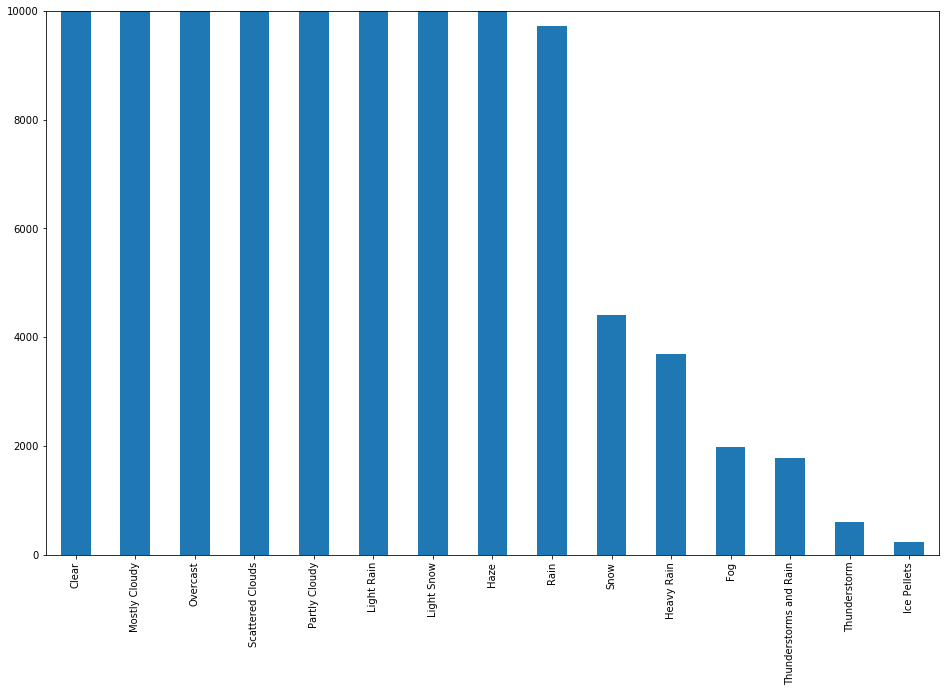

In [14]:
plt.figure(figsize=(16,10))
df['conditions'].value_counts().plot(kind='bar')
plt.ylim([0, 10000])

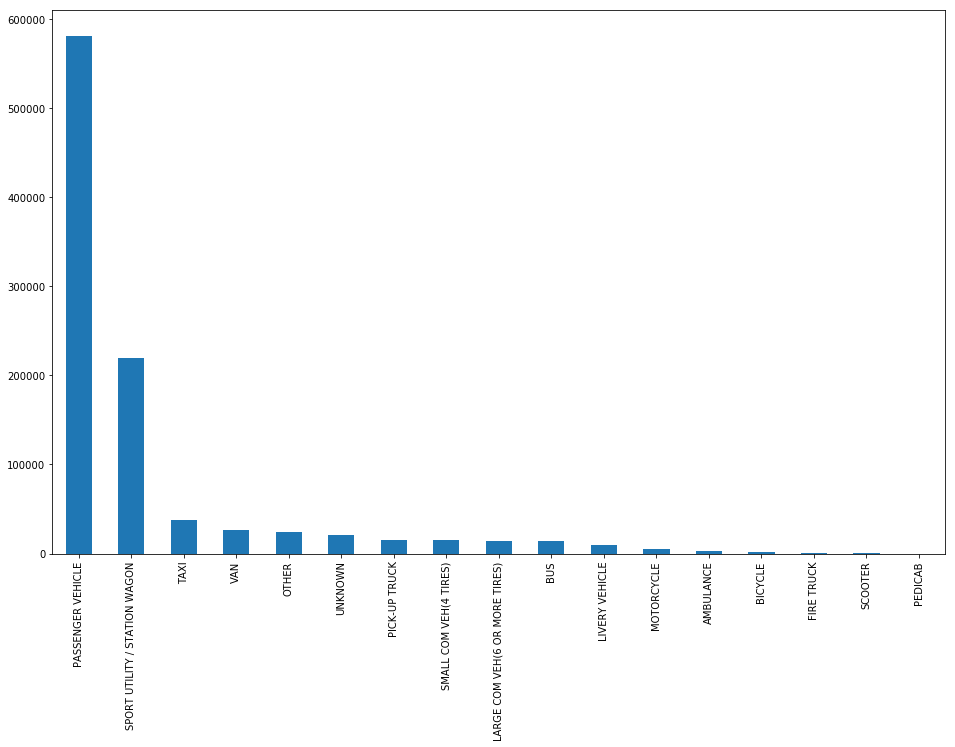

In [15]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [16]:
remap_vehicle = {'TAXI': 'SMALL COM VEH(4 TIRES)',
                'BUS': 'LARGE VEHICLE',
                'SCOOTER': 'MOTORCYCLE',
                'LIVERY VEHICLE': 'SMALL COM VEH(4 TIRES)',
                'VAN': 'MEDIUM VEHICLE',
                'PEDICAB': 'BICYCLE',
                'PICK-UP TRUCK': 'MEDIUM VEHICLE',
                'SPORT UTILITY / STATION WAGON': 'MEDIUM VEHICLE',
                'LARGE COM VEH(6 OR MORE TIRES)': 'LARGE VEHICLE',
                'FIRE TRUCK': 'LARGE VEHICLE',
                }

In [17]:
for column in ['vehicle_type_code_1', 'vehicle_type_code_2',
       'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']:
    df[column] = df[column].replace(remap_vehicle)

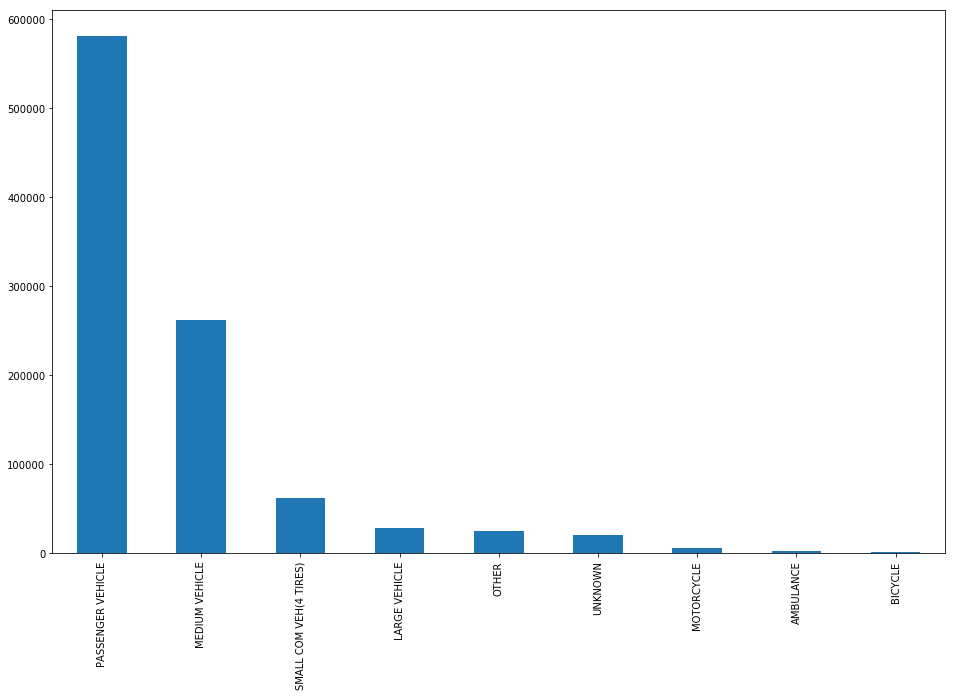

In [18]:
plt.figure(figsize=(16,10))
df['vehicle_type_code_1'].value_counts().plot(kind='bar')

In [19]:
df['rise_time'] = pd.to_datetime(df.rise_time).dt.hour*60 + pd.to_datetime(df.rise_time).dt.minute
df['set_time'] = pd.to_datetime(df.set_time).dt.hour*60 + pd.to_datetime(df.set_time).dt.minute

In [20]:
floats = ['latitude', 'longitude','temperature', 'heat_index', 'dew_point', 'humidity', 'pressure',\
          'visibility', 'wind_speed', 'gust_speed', 'precip', 'zip_code']

In [21]:
for column in floats:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [22]:
with open(path+"data_for_training/v4/predrop_collisions.pkl", 'wb') as outfile:
    pickle.dump(df, outfile)

In [23]:
drop_columns = ['location', 'on_street_name', 'cross_street_name',
       'off_street_name', 'number_of_persons_injured',
       'number_of_persons_killed', 'number_of_pedestrians_injured',
       'number_of_pedestrians_killed', 'number_of_cyclist_injured',
       'number_of_cyclist_killed', 'number_of_motorist_injured',
       'number_of_motorist_killed', 'contributing_factor_vehicle_1',
       'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3',
       'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5',
        'injured', 'killed']

In [24]:
df = df.drop(drop_columns, axis=1)

In [25]:
def fill_nas(df):
    
    for column in df:
        if np.sum(df[column].isnull()) > 0:
            df[column+'_nan'] = df[column].isnull()

            if column == 'zip_code':
                df[column].fillna(df[column].mode()[0], inplace=True)
            elif column in df._get_numeric_data().columns.values:
                df[column].fillna(df[column].mean(), inplace=True)
                
    return df
            
df = fill_nas(df)

In [26]:
onehotdf = pd.get_dummies(df, columns=['borough', 'wind_dir', 'conditions', 'lat/long_infered',
                                      'vehicle_type_code_1', 'vehicle_type_code_2', 'vehicle_type_code_3',
                                      'vehicle_type_code_4', 'vehicle_type_code_5'])

In [27]:
renamed_columns = [x.lower().replace(' ', '_') for x in onehotdf.columns.values]
    
onehotdf.columns = renamed_columns

In [28]:
with open(path+"data_for_training/v4/collisions_1hot.pkl", 'wb') as outfile:
    pickle.dump(onehotdf, outfile)

In [29]:
with open(path+"data_for_training/v4/collisions_no1hot.pkl", 'wb') as outfile:
    pickle.dump(df, outfile)

In [30]:
view_date = pd.to_datetime(df['date_time'])

train_indices = (0, np.sum(view_date < datetime.date(2015,9,12))-1)
val_indices = (train_indices[1]+1,\
               train_indices[1] + \
               np.sum((view_date >= datetime.date(2015,9,12)) & (view_date < datetime.date(2016,7,31))))
test_indices = (val_indices[1]+1,\
               val_indices[1] + np.sum(view_date >= datetime.date(2016,7,31)))

In [31]:
train = df.iloc[train_indices[0]:train_indices[1]]
val = df.iloc[val_indices[0]:val_indices[1]]
test = df.iloc[test_indices[0]:test_indices[1]]

In [32]:
train_count = np.sum(train['num_bicycle'] > 0)
val_count = np.sum(val['num_bicycle'] > 0)
test_count = np.sum(test['num_bicycle'] > 0)
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

65.91, 19.26, 14.83


In [33]:
train_count = np.sum((train['num_vehicles'] == 1) & (train['num_bicycle'] == 0))
val_count = np.sum((val['num_vehicles'] == 1) & (val['num_bicycle'] == 0))
test_count = np.sum((test['num_vehicles'] == 1) & (test['num_bicycle'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

51.36, 20.26, 28.38


In [34]:
train_count = np.sum((train['num_vehicles'] == 0))
val_count = np.sum((val['num_vehicles'] == 0))
test_count = np.sum((test['num_vehicles'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

18.46, 16.88, 64.66


In [35]:
train_count = np.sum((train['num_vehicles'] > 1) & (train['num_bicycle'] == 0))
val_count = np.sum((val['num_vehicles'] > 1) & (val['num_bicycle'] == 0))
test_count = np.sum((test['num_vehicles'] > 1) & (test['num_bicycle'] == 0))
total = train_count + val_count + test_count

print ("%.2f, %.2f, %.2f" % (train_count/total*100, val_count/total*100, test_count/total*100))

68.96, 19.87, 11.17


In [36]:
onehotdf.columns.values

array(['date_time', 'zip_code', 'latitude', 'longitude',
       'congestion/gridlock_0.001', 'chronic_speeding_0.001',
       'drag_racing_0.001', 'chronic_stoplight_violation_0.001',
       'truck_route_violation_0.001', 'congestion/gridlock_0.002',
       'chronic_speeding_0.002', 'drag_racing_0.002',
       'chronic_stoplight_violation_0.002', 'truck_route_violation_0.002',
       'congestion/gridlock_0.005', 'chronic_speeding_0.005',
       'chronic_stoplight_violation_0.005', 'drag_racing_0.005',
       'truck_route_violation_0.005', 'chronic_speeding_0.03',
       'chronic_stoplight_violation_0.03', 'congestion/gridlock_0.03',
       'drag_racing_0.03', 'truck_route_violation_0.03',
       'chronic_speeding_0.06', 'chronic_stoplight_violation_0.06',
       'congestion/gridlock_0.06', 'drag_racing_0.06',
       'truck_route_violation_0.06', 'chronic_speeding_0.1',
       'chronic_stoplight_violation_0.1', 'congestion/gridlock_0.1',
       'drag_racing_0.1', 'truck_route_violation_

In [37]:
csvfile = open(path+'features.csv', 'w')
csvwriter = csv.writer(csvfile)
for item in df.columns.values:
    if '_nan' not in item:
        csvwriter.writerow([item])
csvfile.close()

In [38]:
bike = onehotdf[onehotdf['num_bicycle'] > 0]

In [39]:
one = onehotdf[(onehotdf['num_vehicles'] == 1) & (onehotdf['num_bicycle'] == 0)]

In [40]:
multi = onehotdf[(onehotdf['num_vehicles'] > 1) & (onehotdf['num_bicycle'] == 0)]

In [42]:
with open(path+"data_for_training/v4/split/bike.pkl", 'wb') as outfile:
    pickle.dump(bike, outfile)
with open(path+"data_for_training/v4/split/one.pkl", 'wb') as outfile:
    pickle.dump(one, outfile)
with open(path+"data_for_training/v4/split/multi.pkl", 'wb') as outfile:
    pickle.dump(multi, outfile)

In [45]:
onehotdf.columns.values

array(['date_time', 'zip_code', 'latitude', 'longitude',
       'congestion/gridlock_0.001', 'chronic_speeding_0.001',
       'drag_racing_0.001', 'chronic_stoplight_violation_0.001',
       'truck_route_violation_0.001', 'congestion/gridlock_0.002',
       'chronic_speeding_0.002', 'drag_racing_0.002',
       'chronic_stoplight_violation_0.002', 'truck_route_violation_0.002',
       'congestion/gridlock_0.005', 'chronic_speeding_0.005',
       'chronic_stoplight_violation_0.005', 'drag_racing_0.005',
       'truck_route_violation_0.005', 'chronic_speeding_0.03',
       'chronic_stoplight_violation_0.03', 'congestion/gridlock_0.03',
       'drag_racing_0.03', 'truck_route_violation_0.03',
       'chronic_speeding_0.06', 'chronic_stoplight_violation_0.06',
       'congestion/gridlock_0.06', 'drag_racing_0.06',
       'truck_route_violation_0.06', 'chronic_speeding_0.1',
       'chronic_stoplight_violation_0.1', 'congestion/gridlock_0.1',
       'drag_racing_0.1', 'truck_route_violation_